In [1]:
# Start ferret
import pyferret
import numpy as np
pyferret.start(quiet=True)


True

In [2]:
# Load the data set and store as a Python variable
# Python dictionaries are a type of variable that
# stores the data along with its metadata.
(error_value, error_message) = pyferret.run('use /home/jovyan/data/1_mesh_mask.nc')
glamt_dict = pyferret.getdata('glamt',False)
gphit_dict = pyferret.getdata('gphit',False)

# Also, use some existing masking in Ferret to zero
# out any area points.
(error_value, error_message) = pyferret.run('let area = e1t[d=1]*e2t[d=1]*tmask[d=1,k=1]')
area_masked_dict = pyferret.getdata('area',False)

(error_value, error_message) = pyferret.run('let area = e1t[d=1]*e2t[d=1]')
area_dict = pyferret.getdata('area',False)

# The "keys" are the names of the entries in the
# dictionary - its pieces.
glamt_dict.keys()

dict_keys(['title', 'data', 'missing_value', 'data_unit', 'axis_types', 'axis_names', 'axis_units', 'axis_coords'])

In [3]:
# Get data directly from the dictionary object (which
# includes metadata) and squeeze out unnecessary
# index places.
glamt = np.squeeze(glamt_dict['data'])
gphit = np.squeeze(gphit_dict['data'])
area = np.squeeze(area_dict['data'])
area_masked = np.squeeze(area_masked_dict['data'])

# Get the sizes of the arrays. _m -> max
im,jm = np.shape(glamt)

np.shape(glamt_dict['data'])

(1784, 1719, 1, 1, 1, 1)

In [4]:
# Need to rotate the array to plot North upward
# Experiments with this suggest that it doesn't
# work as I initially expected.
# Need to do more experiments.
#glamt = np.reshape(glamt,(jm,-1), order='C')
#gphit = np.reshape(gphit,(jm,-1), order='C')

# Instead, here we need to specify the other grid
# parameters. 
# Depth is always 1 for this dataset.
km = 1  
# Start at 731 (1st snap after 10 years of spin up, 1958)
# End at 4526 (endpoint of data set, note +1 for python)
lstart = 731
#lend = 876
lend = 4526

# We want to finish with monthly data, so with 73 steps/year,
# that is approximately 6 steps going into each month.  We'll
# just take the 7th step in the last month.  Hard code the
# number of steps.
lmn = 52*12

# This is the monthly stepping.  LMN will not automatically
# adjust!
linc = 6

# And now specify the amount of cutting down ( _bm ->
# blockmean) and the size of the output array.  Grid
# can be selectively cut in x(i) or y(j) axis.  For
# example, 20 on a 1/20 deg. grid -> 1 degree output.
ibm = 20
jbm = 20

# The new max values, _mn, are calculated here.  Any partial
# boxes on the far Northern/Eastern side will be ignored.
imn = int(im/ibm)
jmn = int(jm/jbm)

# Create output arrays
glamt_new = np.zeros((imn,jmn,km,1,1,1))
gphit_new = np.zeros((imn,jmn,km,1,1,1))
ssh_new = np.zeros((imn,jmn,km,lmn,1,1))

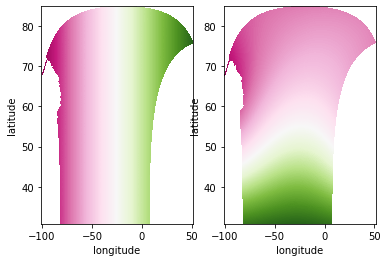

In [5]:
# Make a plot to verify that data have been loaded
# Using pcolormesh is good because it explicitly
# requires the pixel locations rather than implicit
# pixel locations with an image plotting tool.
import matplotlib.pyplot as plt
cmap = plt.get_cmap('PiYG')
# Use tuple unpacking to list the axes.
# See: https://matplotlib.org/3.1.0/gallery/subplots_axes_and_figures/subplots_demo.html
fig, axs = plt.subplots(ncols=2)
axs[0].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],glamt[1:im-2,1:jm-2], cmap=cmap)
#axs[1].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2], cmap=cmap)
axs[1].pcolormesh(glamt[1:im-2,1:jm-2],gphit[1:im-2,1:jm-2],area[1:im-2,1:jm-2], cmap=cmap)

for ax in axs:
    ax.set(xlabel='longitude',ylabel='latitude')

plt.show()

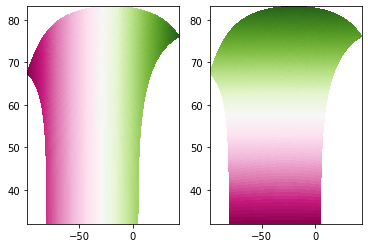

In [6]:
# Multiply arrays to be averaged by weight (area in this case)
glamt_w = np.multiply(glamt,area)
gphit_w = np.multiply(gphit,area)

# Create cut down versions of the lon, lat grids
# Loop limits are in FORTRAN/Ferret notation (counting
# starts at 1) and the data is written to the Python
# variable with Python counting (starting at 0) by
# subtracting 1 at the time of data storage.
for ii in range(1,imn+1):
    
    # Comments for index logic.  Same logic
    # for j direction.
    # For ii = 1, we want exactly 1.
    # For ii = imn, we want start of the last block,
    #  which is +1 of the end of the previous block.
    # Finally, note all subtract 1 because Python
    # index counting starts at 0.
    istart = 1+ibm*(ii-1) - 1
    
    # For ii = 1, we want the end of the first block
    # For ii = imn, we want the end of the last block
    iend = ibm*ii - 1
    
    for jj in range(1,jmn+1):

        jstart = 1+jbm*(jj-1) - 1 
        jend = jbm*jj - 1
        
        # We use area here (and not the masked area as below)
        # because glamt and gphit are coordinates and so they
        # have valid data over land as well as over the ocean.
        glamt_new[ii-1,jj-1,0,0,0,0] = np.sum(
            glamt_w[istart:iend,jstart:jend])/np.sum(area[istart:iend,jstart:jend])
        gphit_new[ii-1,jj-1,0,0,0,0] = np.sum(
            gphit_w[istart:iend,jstart:jend])/np.sum(area[istart:iend,jstart:jend])
        
# Plot to see if the results make sense
glamt_new_plt = np.squeeze(glamt_new)
gphit_new_plt = np.squeeze(gphit_new)
fig, axs = plt.subplots(ncols=2)
axs[0].pcolormesh(glamt_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2],glamt_new_plt[1:imn-2,1:jmn-2], cmap=cmap)
axs[1].pcolormesh(glamt_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2],gphit_new_plt[1:imn-2,1:jmn-2], cmap=cmap)

In [7]:
# Clear some extraneous variables before we do the heavy crunching.
del glamt_w
del gphit_w


In [8]:
# Load SSH data
(error_value, error_message) = pyferret.run('use /home/jovyan/data/V20_1948_2009_SSH.nc')

# Ideally, here we load the time step information
# and allow the code to automatically pull this
# from the data.  However, I'm not doing that here
# because I cannot load the whole file to memory
# and I don't want to do any text processing from
# the Ferret show data command.

In [9]:
# Now all we need to do is iterate over the time index,
# passing a new string object to ferret to get that field
# and then apply the blockmean operation on the field
# and store the output.
#
# Since we want to compute monthly means, compute the
# monthly means in pyferret first, then export those data
# here for blockmean.  Time average is OK in pyferret
# b/c time axis is known.  The spatial averages is done
# here because of the area weighting of curvilinear grids.
#
# The ability to go in and out of ferret at will is AWESOME
# for complicated tasks like this.
ll = lstart # index for data in Ferret
ll_year = 1 # index of step within year
ll_out = 0  # index of monthly data in Python

yy = 1958
mm = 1
dd = 15
hh = 12

while ll < lend:
    # Test loop ranges
    print(str(ll),str(ll_year),str(yy),str(mm))
    
    # Test whether we are at the end of the year
    if (ll_year < 67):
        # Step forward 5 units (for 6 total units in avg)
        ll_next = ll + linc - 1
        
        # Move the year counter forward to next loop!
        ll_year = ll_year + 6
        
        # Keep the year the same
        yy_next = yy
        
        # Keep track of month for next loop
        mm_next = mm + 1
                
    else:
        ll_next = ll + linc
        
        # Reset year counter
        ll_year = 1
        
        # Keep track of year for next loop
        yy_next = yy + 1
        
        # Reset to January for next year
        mm_next = 1
        
        print('Found December!')
    
    # Load data from this time step
    (error_value, error_message) = pyferret.run('let ssh_month = sossheig[d=2,l='+str(ll)+':'+str(ll_next)+'@AVE]')
    ssh_dict = pyferret.getdata('ssh_month',False)
    ssh = np.squeeze(ssh_dict['data'])
    ssh_w = np.multiply(ssh,area_masked)
    
    # Store time coordinate
    if ll == lstart:
        # Convert tuple to list to be able to append
        axis_coords = list(ssh_dict['axis_coords'])
    else:
        coords = ssh_dict['axis_coords']
        axis_coords[3] = np.append(axis_coords[3],coords[3],axis=0)
        
    # Set the year, month, and day since
    # ferret does not export date in metadata
    # for time averaged field.
    axis_coords[3][-1][0] = dd
    axis_coords[3][-1][1] = mm
    axis_coords[3][-1][2] = yy
    axis_coords[3][-1][3] = hh
    axis_coords[3][-1][4] = 0
    axis_coords[3][-1][5] = 0
    
    # Find number of missing values and post warning if present
    missing = np.abs(ssh - ssh_dict['missing_value']) < 1.0E-5
    if np.sum(missing) > 0:
        print('Warning! Missing values dectected!')
    
    del ssh
    
    # Cut data down and save to array.  See
    # how glamt and gphit were cut down for
    # comments on the logic.
    for ii in range(1,imn+1):
        
        istart = 1+ibm*(ii-1) - 1
        iend = ibm*ii - 1
        
        for jj in range(1,jmn+1):
            
            jstart = 1+jbm*(jj-1) - 1 
            jend = jbm*jj - 1
        
            # Need to check for land (empty) data points
            # and ensure that fill values on land do not
            # "bleed" into the averages near the coast.
            denominator = np.sum(area_masked[istart:iend,jstart:jend])
            missing_value = ssh_dict['missing_value']
            if denominator == 0:
                ssh_new[ii-1,jj-1,0,ll_out,0,0] = missing_value[0]
            else:
                ssh_new[ii-1,jj-1,0,ll_out,0,0] = np.sum(
                ssh_w[istart:iend,jstart:jend])/denominator
                
    # Final logic to complete the time looping.
    ll = ll_next + 1
    ll_out = ll_out + 1
    
    yy = yy_next
    mm = mm_next


731 1 1958 1
737 7 1958 2
743 13 1958 3
749 19 1958 4
755 25 1958 5
761 31 1958 6
767 37 1958 7
773 43 1958 8
779 49 1958 9
785 55 1958 10
791 61 1958 11
797 67 1958 12
Found December!
804 1 1959 1
810 7 1959 2
816 13 1959 3
822 19 1959 4
828 25 1959 5
834 31 1959 6
840 37 1959 7
846 43 1959 8
852 49 1959 9
858 55 1959 10
864 61 1959 11
870 67 1959 12
Found December!
877 1 1960 1
883 7 1960 2
889 13 1960 3
895 19 1960 4
901 25 1960 5
907 31 1960 6
913 37 1960 7
919 43 1960 8
925 49 1960 9
931 55 1960 10
937 61 1960 11
943 67 1960 12
Found December!
950 1 1961 1
956 7 1961 2
962 13 1961 3
968 19 1961 4
974 25 1961 5
980 31 1961 6
986 37 1961 7
992 43 1961 8
998 49 1961 9
1004 55 1961 10
1010 61 1961 11
1016 67 1961 12
Found December!
1023 1 1962 1
1029 7 1962 2
1035 13 1962 3
1041 19 1962 4
1047 25 1962 5
1053 31 1962 6
1059 37 1962 7
1065 43 1962 8
1071 49 1962 9
1077 55 1962 10
1083 61 1962 11
1089 67 1962 12
Found December!
1096 1 1963 1
1102 7 1963 2
1108 13 1963 3
1114 19 1963 4
11

3797 1 2000 1
3803 7 2000 2
3809 13 2000 3
3815 19 2000 4
3821 25 2000 5
3827 31 2000 6
3833 37 2000 7
3839 43 2000 8
3845 49 2000 9
3851 55 2000 10
3857 61 2000 11
3863 67 2000 12
Found December!
3870 1 2001 1
3876 7 2001 2
3882 13 2001 3
3888 19 2001 4
3894 25 2001 5
3900 31 2001 6
3906 37 2001 7
3912 43 2001 8
3918 49 2001 9
3924 55 2001 10
3930 61 2001 11
3936 67 2001 12
Found December!
3943 1 2002 1
3949 7 2002 2
3955 13 2002 3
3961 19 2002 4
3967 25 2002 5
3973 31 2002 6
3979 37 2002 7
3985 43 2002 8
3991 49 2002 9
3997 55 2002 10
4003 61 2002 11
4009 67 2002 12
Found December!
4016 1 2003 1
4022 7 2003 2
4028 13 2003 3
4034 19 2003 4
4040 25 2003 5
4046 31 2003 6
4052 37 2003 7
4058 43 2003 8
4064 49 2003 9
4070 55 2003 10
4076 61 2003 11
4082 67 2003 12
Found December!
4089 1 2004 1
4095 7 2004 2
4101 13 2004 3
4107 19 2004 4
4113 25 2004 5
4119 31 2004 6
4125 37 2004 7
4131 43 2004 8
4137 49 2004 9
4143 55 2004 10
4149 61 2004 11
4155 67 2004 12
Found December!
4162 1 2005 1
4

In [10]:
# Assign metadata keys to variables to save.ssh_dict.keys()
# We need the following keys (see output of first cell)
# See example code at: https://ferret.pmel.noaa.gov/Ferret/documentation/pyferret/example-sessions-python
# And more detailed docs for the metadata at:
# https://ferret.pmel.noaa.gov/Ferret/documentation/pyferret/data-dictionaries
# dict_keys([
#   'title', # long title
#   'data', # assign ssh_new
#   'missing_value', # array([9.96920997e+36]) = no change, they are applied above.
#   'data_unit',  # 'm' - no change
#   'axis_types', # (6,6,7,4,7,7) = (abstract,abstract,empty,time,empty,empty) = no change
#   'axis_names', # ('X','Y','','TIME','','') = no change
#   'axis_units', # ('', '', '', 'CALTYPE_NOLEAP', '', '') = no change
#   'axis_coords' # needs to go (array([1:imn]),array([1:jmn]),None,array([[dates_of_slices]]),None,None)
# ])
ssh_dict['name'] = 'ssh'
ssh_dict['title'] = 'Regridded SSH'
ssh_dict['data'] = ssh_new

# Reset the axis_coords in x and y directions.
# Include imn and jmn.
axis_coords[0] = np.arange(imn,dtype=float)
axis_coords[1] = np.arange(jmn,dtype=float)

# Do the same for time -> abstract axis is being
# passed from the ferret time means.  This
# overwrite causes an error at import time because
# the time axis must have 6 units per entry.
#axis_coords[3] = np.arange(lmn,dtype=float)

# The above lines are correct except that a bug in
# pyferret throws an error if there is more than one
# value in an abstract data list (i.e. pyferret will
# not load data it has just gotten).  One way around
# this is to just set the abstract axes to None and
# then pyferret will use np.arange exactly the way
# I have used it above to automatically assign
# indeces. For bug reporting, the error is on
# line 543 of /opt/conda/envs/pyferret/lib/python3.8/site-packages/pyferret/datamethods.py
# and a solution may be 'if any(axis_coords[k] != None):'
#axis_coords[0] = None
#axis_coords[1] = None

# Convert list to tuple to match original format
# and assign.
ssh_dict['axis_coords'] = tuple(axis_coords)

# Clear all data and axes in ferret
(error_value, error_message) = pyferret.run('cancel data /all')
(error_value, error_message) = pyferret.run('cancel axis /all')
#(error_value, error_message) = pyferret.run('cancel memory /all')

# Put the data into pyferret
pyferret.putdata(ssh_dict)

# Similar metadata operations for glamt and gphit
axis_coords = list(glamt_dict['axis_coords'])
axis_coords[0] = np.arange(imn,dtype=float)
axis_coords[1] = np.arange(jmn,dtype=float)
axis_coords[2] = None
axis_coords[3] = None
axis_coords[4] = None
axis_coords[5] = None
glamt_dict['axis_coords'] = tuple(axis_coords)
gphit_dict['axis_coords'] = tuple(axis_coords)

# Set time in the grids to orthogonal to data
axis_types = list(glamt_dict['axis_types'])
axis_types[2] = 7
axis_types[3] = 7
glamt_dict['axis_types'] = tuple(axis_types)
gphit_dict['axis_types'] = tuple(axis_types)

glamt_dict['name'] = 'glamt'
gphit_dict['name'] = 'gphit'

glamt_dict['data'] = glamt_new
gphit_dict['data'] = gphit_new

pyferret.putdata(glamt_dict)
pyferret.putdata(gphit_dict)

# Save the output as a NetCDF file for later
(error_value, error_message) = pyferret.run('set memory /size=2000')
(error_value, error_message) = pyferret.run('save /clobber /file=V20_1958_2009_SSH_regridded.nc ssh,glamt,gphit')
